In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
#https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/helper.py
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [3]:
IMAGE_FOLDER='D:\private-ai\sg-intro-ai-challenge\Eye_diseases'
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], 
                                                     [0.5, 0.5, 0.5])])
dataset = datasets.ImageFolder(IMAGE_FOLDER, transform=transform)

In [4]:
#check the class labels
classes = dataset.classes
print(classes)

['Bulging_Eyes', 'Cataracts', 'Crossed_Eyes', 'Glaucoma', 'Uveitis']


In [5]:
#test train split 80:20
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
#split into train validation 80:20
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

In [6]:
#test train data loaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=10, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True)

torch.Size([10, 3, 224, 224])
torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


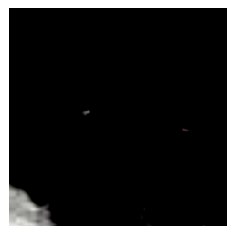

In [7]:
#check the train dataloader
images, labels = next(iter(train_dataloader))
print(images.shape)
print(labels.shape)
imshow(images[0], normalize=False)

torch.Size([77, 3, 224, 224])
torch.Size([77])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


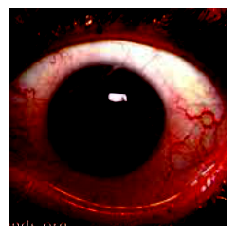

In [8]:
#check the test dataloader
images, labels = next(iter(test_dataloader))
print(images.shape)
print(labels.shape)
imshow(images[0], normalize=False)

In [9]:
# define the CNN architecture
class SimpleCNN(torch.nn.Module):
        
    def __init__(self): 
        super(SimpleCNN, self).__init__()
        #convolution layers
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=5, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(18, 36, kernel_size=5, stride=1, padding=1)
        
        #max pooling layers
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #Linear layers
        self.fc1 = torch.nn.Linear(36 * 54 * 54, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)
        
        #dropout layer
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))            
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 36 * 54 * 54)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return(x)

# create the CNN model
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 18, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(18, 36, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=104976, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


In [10]:
# specify the categorical cross-entropy loss function
criterion = nn.CrossEntropyLoss()
# specify the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [11]:
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    
    train_loss = 0.0
    valid_loss = 0.0
    
    #train the model
    #model.train()
    for data, target in train_dataloader:        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)                
        
    #validate the model    
    #model.eval()
    for data, target in valid_dataloader:
        output = model(data)
        loss = criterion(output, target)
         
        valid_loss += loss.item()*data.size(0)
        
    #average train and validation loss
    train_loss = train_loss/len(train_dataloader.sampler)
    valid_loss = valid_loss/len(valid_dataloader.sampler)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 1.846235 	Validation Loss: 1.602869
Epoch: 2 	Training Loss: 1.538286 	Validation Loss: 1.559010
Epoch: 3 	Training Loss: 1.432268 	Validation Loss: 1.512681
Epoch: 4 	Training Loss: 1.402013 	Validation Loss: 1.471109
Epoch: 5 	Training Loss: 1.399540 	Validation Loss: 1.601827
Epoch: 6 	Training Loss: 1.383001 	Validation Loss: 1.471556
Epoch: 7 	Training Loss: 1.335443 	Validation Loss: 1.567266
Epoch: 8 	Training Loss: 1.328587 	Validation Loss: 1.532429
Epoch: 9 	Training Loss: 1.239415 	Validation Loss: 1.451797
Epoch: 10 	Training Loss: 1.270885 	Validation Loss: 1.421590
Epoch: 11 	Training Loss: 1.219056 	Validation Loss: 1.603762
Epoch: 12 	Training Loss: 1.197526 	Validation Loss: 1.387492
Epoch: 13 	Training Loss: 1.131402 	Validation Loss: 1.474157
Epoch: 14 	Training Loss: 1.097881 	Validation Loss: 1.633675
Epoch: 15 	Training Loss: 1.062724 	Validation Loss: 1.451963
Epoch: 16 	Training Loss: 0.986755 	Validation Loss: 1.547248
Epoch: 17 	Traini

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label: Cataracts 	 Predicted label:  Crossed_Eyes


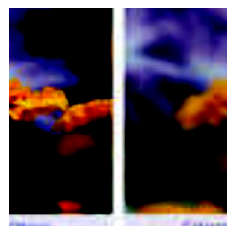

In [12]:
# predict on the test set dataloader
dataiter = iter(test_dataloader)
images, labels = dataiter.next()
imshow(images[0], normalize=False)
images.numpy()

#predict the class
output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())
print('True label: {} \t Predicted label: '.format(classes[labels[0]]), classes[preds[0]])

In [13]:
#create a confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, preds_tensor)
cm

array([[ 0,  1,  8,  0,  0],
       [ 0,  1,  5,  0,  1],
       [ 0,  5, 23,  3,  5],
       [ 0,  4,  8,  0,  2],
       [ 0,  1,  2,  1,  7]], dtype=int64)